In [1]:
#data_analysis env
import pygam
from pygam import LinearGAM, s, f
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#segoeui font
plt.rcParams['font.family'] = 'Segoe UI'

#### Inputs

In [2]:
src_meteo = r"D:\VUB\_data\_isimip_3b\model_outputs\meteo"
src_recharge = r"D:\VUB\_data\_isimip_3b\model_outputs\mHM_Gr_Fluxes"
models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']
meteo_vars = ['pre', 'pet']
scenarios = ['historical', 'ssp585']

In [3]:
def da_to_dict(src, models, scenarios, variables):
    data_dict = {}
    for model in models:
        for scenario in scenarios:
            for variable in variables:
                file_path = f"{src}/{model}/{scenario}/{variable}.nc"
                ds = xr.open_dataset(file_path)
                if variable == 'mHM_Gr_Fluxes':
                    da = ds[['recharge']]
                else:
                    da = ds[[variable]]
                key = f"{model}_{scenario}_{variable}"
                data_dict[key] = da
    return data_dict

In [4]:
#stack models on keys
def stack_models(meteo_dict, model_keys):
    stacked_models_meteo = []

    for key in model_keys:
        model_da = meteo_dict[key].assign_coords(model=key.split("_")[0])
        model_da = model_da.expand_dims("model")
        stacked_models_meteo.append(model_da)

    da = xr.concat(stacked_models_meteo, dim="model")
    return da

In [5]:
def compute_mon_deltas(hydro_dict, var, hist_slice, fut_slice, agg='sum'):
    """
    Return future monthly anomalies (future minus historical monthly climatology).
    Assumes daily data; set agg='mean' if inputs are daily means you want monthly means.
    """
    da_hist = hydro_dict[f'historical_{var}'].sel(time=hist_slice)
    da_fut  = hydro_dict[f'ssp585_{var}'].sel(time=fut_slice)

    # monthly aggregates
    hist_mon = getattr(da_hist.resample(time='ME'), agg)()
    fut_mon  = getattr(da_fut .resample(time='ME'), agg)()

    # historical monthly climatology (1..12)
    hist_mon_clim = hist_mon.groupby('time.month').mean('time')

    # anomalies for each future month (retain future time axis)
    fut_mon_anom = fut_mon.groupby('time.month') - hist_mon_clim

    # optional rename for recharge
    if var == 'mHM_Gr_Fluxes':
        fut_mon_anom = fut_mon_anom.rename({'mHM_Gr_Fluxes': 'recharge'})

    return fut_mon_anom  # dims: time (monthly in future window), y, x


In [6]:
def ens_stats(models_dict, scenarios, vars_list):
    stats_dict = {}
    for scenario in scenarios:
        for variable in vars_list:
            stacked_models = stack_models(models_dict, [key for key in models_dict.keys() if scenario in key and variable in key])

            #compute ensemble mean
            ens_mean = stacked_models.mean(dim='model')
            stats_dict[f"{scenario}_{variable}"] = ens_mean
    return stats_dict

#### Compute ensemble statistics

In [7]:
#Group data into dictionaries
meteo_dict = da_to_dict(src_meteo, models, scenarios, meteo_vars)
recharge_dict = da_to_dict(src_recharge, models, scenarios, ['mHM_Gr_Fluxes'])

#Compute ensemble means
ens_meteo_mean = ens_stats(meteo_dict, scenarios, meteo_vars)
ens_recharge_mean = ens_stats(recharge_dict, scenarios, ['mHM_Gr_Fluxes'])
#replace mHM_Gr_Fluxes key with recharge
ens_recharge_mean = {key.replace('mHM_Gr_Fluxes', 'recharge'): value for key, value in ens_recharge_mean.items()}

In [8]:
#calculate water availability (p-pet) per scenario
water_availability = {}
for scenario in scenarios:
    pre = ens_meteo_mean[f"{scenario}_pre"]
    pet = ens_meteo_mean[f"{scenario}_pet"]
    wa = pre['pre'] - pet['pet']
    #wa to dataset
    wa = wa.to_dataset(name='wa')
    water_availability[f"{scenario}_wa"] = wa

#### Compute future changes

In [9]:
#resample to monthly and calculate changes
hist_time_slice = slice('1981-01-01', '2010-12-31')
fut_time_slice = slice('2071-01-01', '2100-12-31')

pre_delta = compute_mon_deltas(ens_meteo_mean, 'pre', hist_time_slice, fut_time_slice)
pet_delta = compute_mon_deltas(ens_meteo_mean, 'pet', hist_time_slice, fut_time_slice)
wa_delta = compute_mon_deltas(water_availability, 'wa', hist_time_slice, fut_time_slice)
recharge_delta = compute_mon_deltas(ens_recharge_mean, 'recharge', hist_time_slice, fut_time_slice)

#### Extract timeseries of features

In [10]:
#Soil regions of interest
names = ['Loess Region','Ardennen','Campine']

#create df of regions and their coordinates (these are subsets of the regions not the entire regions)
roi_df = pd.DataFrame(index=names, columns=['min_lon','min_lat','max_lon','max_lat'])
roi_df.loc['Ardennen'] = [5.20, 49.90, 5.7, 50.4]
roi_df.loc['Campine'] = [4.45,50.90, 5.50, 51.40]
roi_df.loc['Loess Region'] = [4.6, 50.5, 5.2, 50.9]


dx = 0.05
dy = 0.05

#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'name'}, inplace=True)

In [11]:
roi_df

,name,min_lon,min_lat,max_lon,max_lat
0,Loess Region,4.6,50.5,5.2,50.9
1,Ardennen,5.2,49.9,5.7,50.4
2,Campine,4.45,50.9,5.5,51.4


In [12]:
#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy
bbox_dict = {}
for index, row in roi_df.iterrows():
    name = row['name']
    min_lon = row['min_lon']
    min_lat = row['min_lat']
    max_lon = row['max_lon']
    max_lat = row['max_lat']

    #lon/lat ranges with dx, dy
    lat_range = np.arange(min_lat, max_lat+dy, dy)
    lon_range = np.arange(min_lon, max_lon+dx, dx)
    bbox_dict[name] = {'lat': lat_range, 'lon': lon_range}

In [42]:
type(bbox_dict['Ardennen'])

dict

In [ ]:
def extract_roi_timeseries(da, bbox_dict, region_name=None):
    da_df_list = []
    for key in bbox_dict:
        if region_name and key != region_name:
            continue
        bbox_df = bbox_dict[key]
        lat_range = bbox_df['lat']
        lon_range = bbox_df['lon']
        for i in range(len(lon_range)-1):
            lon_min = lon_range[i]
            lon_max = lon_range[i+1]
            for j in range(len(lat_range)-1):
                lat_min = lat_range[j]
                lat_max = lat_range[j+1]

                #extract timeseries of the subregions within roi
                da_subset = da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_max, lat_min))
                da_subset = da.where(
            (da.lon >= lon_min) & (da.lon < lon_max) &
            (da.lat >= lat_min) & (da.lat < lat_max),
            drop=True
        )
                #calculate mean of the region
                da_df = da_subset.mean(dim=['lat', 'lon']).to_dataframe().drop(columns=['month'])
                #drop da if it contains NaN values
                if not da_df.isnull().values.any():
                    #groupby season with QS-DEC
                    da_df = da_df.resample('QS-DEC').sum()
                    da_df_list.append(da_df)
        #combine all da_df into one df
    da_df = pd.concat(da_df_list, axis=0)
    return da_df

In [18]:
bbox_dict['Ardennen']

{'lat': array([49.9 , 49.95, 50.  , 50.05, 50.1 , 50.15, 50.2 , 50.25, 50.3 ,
        50.35, 50.4 ]),
 'lon': array([5.2 , 5.25, 5.3 , 5.35, 5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 ])}

In [19]:
recharge_delta_roi = extract_roi_timeseries(recharge_delta, bbox_dict)
pre_delta_roi = extract_roi_timeseries(pre_delta, bbox_dict)
pet_delta_roi = extract_roi_timeseries(pet_delta, bbox_dict)
wa_delta_roi = extract_roi_timeseries(wa_delta, bbox_dict)

#### Generalized Additive Model for Recharge change

In [20]:

#prepare dataframe
data = pd.DataFrame({
    'wa': wa_delta_roi['wa'].values,
    'pet': pet_delta_roi['pet'].values,
    'pre': pre_delta_roi['pre'].values,
    'recharge': recharge_delta_roi['recharge'].values[0:len(wa_delta_roi)]
})

#add memory effect of previous water availability
data['wa_lag1'] = data['wa'].shift(1).fillna(0)
data.index = pd.to_datetime(wa_delta_roi.index)

In [21]:
#convert date index to datetime
data.index = pd.to_datetime(data.index)
data_summer = data[data.index.month.isin([6])]
data_autumn = data[data.index.month.isin([9])]
data_winter = data[data.index.month.isin([12])]
data_spring = data[data.index.month.isin([3])]

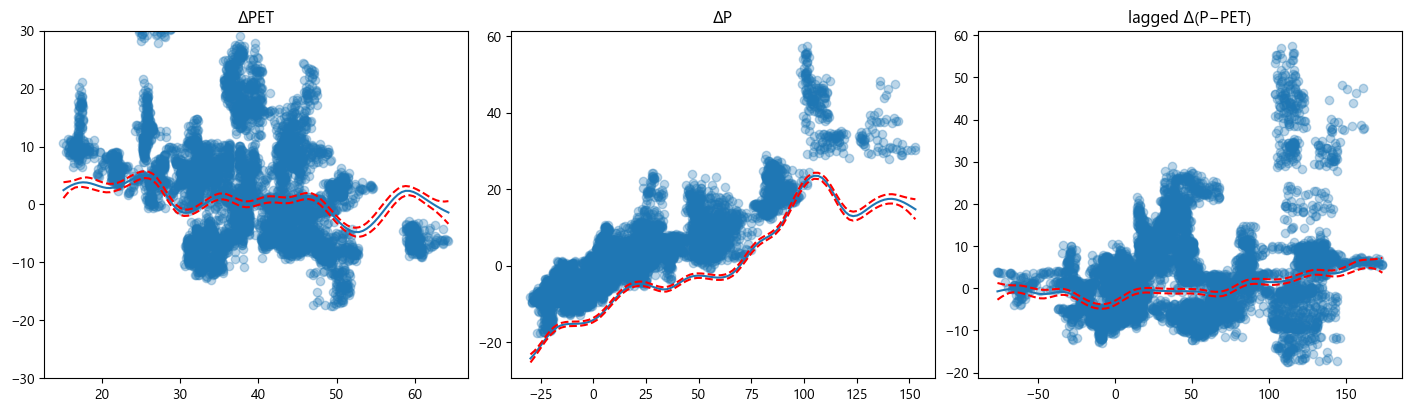

In [23]:
#Build GAM model
X = data_spring[['pet', 'pre', 'wa_lag1']].values
y = data_spring['recharge'].values


# fit (use gridsearch so smoothness is tuned)
gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)


# 1-D partials for pet, pre, wa_lag1  (terms 0,1,3)
titles = ['ΔPET', 'ΔP', 'lagged Δ(P−PET)']
fig, axs = plt.subplots(1, 3, figsize=(14,4), constrained_layout=True)
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #add scatter points
    ax.scatter(X[:, i], y, alpha=0.3)
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = data_autumn[['pet', 'pre', 'wa_lag1']].values
y = data_autumn['recharge'].values

feature_names = ['pet','pre','wa_lag1']  # adjust

#split data into train and test sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [200],        # Number of trees in the forest
    'max_depth': [40],              # Maximum depth of each tree
    'min_samples_split': [3],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2],         # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=5,                        # Number of cross-validation folds
    n_jobs=-1,                   # Number of jobs to run in parallel
    scoring='neg_mean_squared_error' # Strategy to evaluate the performance of the cross-validated model on the test set.
)

# Fit the model
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")


# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
nse = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))

# groups = None

# rf = RandomForestRegressor(
#     n_estimators=800, max_depth=None, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# # Cross-validated R²
# if groups is None:
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     yhat = np.full_like(y, np.nan, dtype=float)
#     for tr, te in kf.split(X):
#         m = RandomForestRegressor(**rf.get_params())
#         m.fit(X[tr], y[tr])
#         yhat[te] = m.predict(X[te])
# else:
#     gkf = GroupKFold(n_splits=min(5, np.unique(groups).size))
#     yhat = np.full_like(y, np.nan, dtype=float)
#     for tr, te in gkf.split(X, y, groups):
#         m = RandomForestRegressor(**rf.get_params())
#         m.fit(X[tr], y[tr])
#         yhat[te] = m.predict(X[te])

# cv_r2 = r2_score(y, yhat)
# print(f"CV R²: {cv_r2:.3f}")

# # Fit on all data for SHAP & plots
# rf.fit(X, y)

Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


R^2:0.785, RMSE:4.22, NSE:0.785



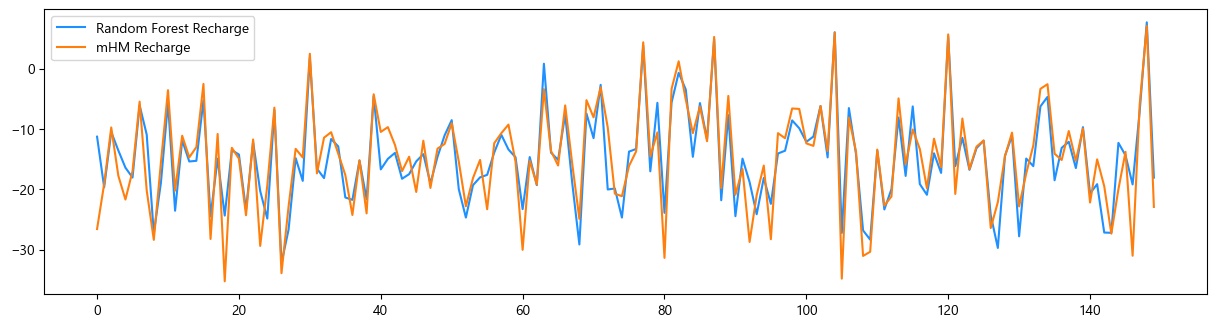

In [37]:
#plot the results vs the observed values
plt.figure(figsize=(15, 3.7))
plt.plot(y_pred[200:350], color='dodgerblue', lw=1.5, label='Random Forest Recharge')
plt.plot(y_test[200:350], color='C1', lw=1.5, label='mHM Recharge')
print(f"R^2:{np.round(r2, 3)}, RMSE:{np.round(rmse, 2)}, NSE:{np.round(nse, 3)}")
print()
#fill 95% confidence interval
# plt.fill_between(np.arange(0,len(y_test[600:900])), y_pred[600:900]-2*rmse, y_pred[600:900]+2*rmse, color='gray', alpha=0.2)

plt.legend()

In [38]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
if isinstance(shap_values, list):  
    shap_values = shap_values[0]

# Mean absolute SHAP (mm of recharge) and importance share
mean_abs = np.mean(np.abs(shap_values), axis=0)
share = mean_abs / (mean_abs.sum() + 1e-12)

imp = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap_mm': mean_abs,
    'share': share
}).sort_values('mean_abs_shap_mm', ascending=False)
# print(imp)

# Optional: bucket to Demand / Moisture / Memory
def bucket(name: str) -> str:
    n = name.lower()
    if 'pre' in n: return 'Moisture (dP)'
    if 'pet' in n:    return 'Demand (dPET)'
    if 'wa_lag1' in n: return 'Memory (d(P−PET))'
    return 'Other'

bucket_imp = (imp.assign(bucket=imp['feature'].map(bucket))
                .groupby('bucket', as_index=False)
                .agg(mean_abs_shap_mm=('mean_abs_shap_mm','sum'))
                .assign(share=lambda d: d['mean_abs_shap_mm']/d['mean_abs_shap_mm'].sum())
                .sort_values('mean_abs_shap_mm', ascending=False))
print(bucket_imp)

              bucket  mean_abs_shap_mm     share
1  Memory (d(P−PET))          3.750002  0.454067
2      Moisture (dP)          2.953644  0.357641
0      Demand (dPET)          1.555046  0.188292


In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
if isinstance(shap_values, list):
    shap_values = shap_values[0]


Text(0.5, 1.0, 'Feature importance - Autumn')

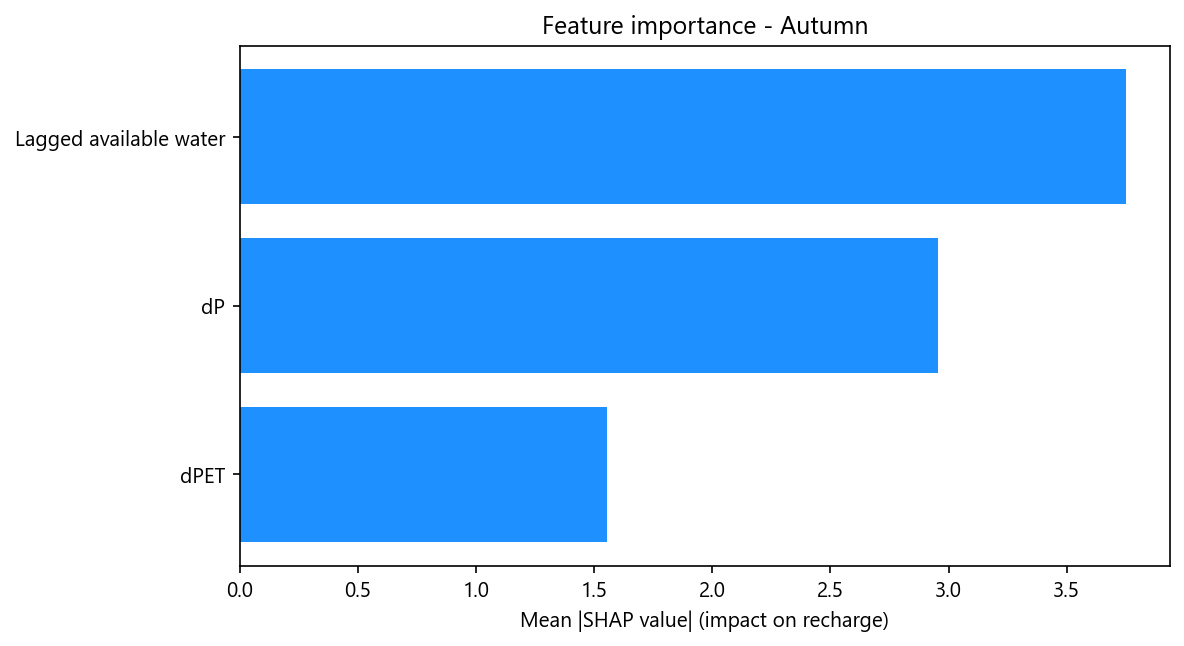

In [40]:

plt.figure(figsize=(8,4.5), dpi=150)
max_shap = abs(shap_values).mean(axis=0)
names = ['dPET', 'dP', 'Lagged available water']
#to df

shap_df = pd.DataFrame({'Feature': names, 'Max_SHAP': max_shap})
#sort df by Max_SHAP descending
shap_df = shap_df.sort_values(by='Max_SHAP', ascending=True)

#plt.bar horizontal
plt.barh(shap_df['Feature'], shap_df['Max_SHAP'], color='dodgerblue')
plt.xlabel('Mean |SHAP value| (impact on recharge)')
plt.title('Feature importance - Autumn')